# The code below is configured for 1-dimensional detuning variation

Beginning...
-------------
Feeding in detuning -150000126.7 1 of 37 Evaluations
u/T recorded: 2.816435266869507 0.004308185713604313 after 9 integral calls.
-------------
Feeding in detuning -145861234.315 2 of 37 Evaluations
u/T recorded: 2.782755519301216 0.004205764725307287 after 9 integral calls.
-------------
Feeding in detuning -141722341.93 3 of 37 Evaluations
u/T recorded: 2.7486137881606907 0.004103196447813833 after 8 integral calls.
-------------
Feeding in detuning -137583449.545 4 of 37 Evaluations
u/T recorded: 2.7139668292173558 0.004000404794969446 after 9 integral calls.
-------------
Feeding in detuning -133444557.16 5 of 37 Evaluations
u/T recorded: 2.678814693127318 0.0038974469566657164 after 9 integral calls.
-------------
Feeding in detuning -129305664.775 6 of 37 Evaluations
u/T recorded: 2.6431274122231803 0.00379429476171424 after 9 integral calls.
-------------
Feeding in detuning -125166772.391 7 of 37 Evaluations
u/T recorded: 2.606877521683678 0.003690932

NameError: name 'start_time' is not defined

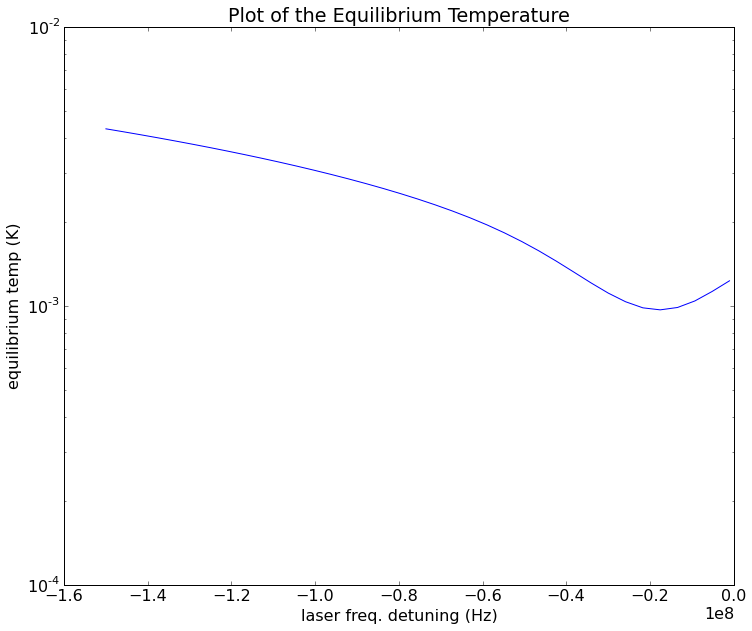

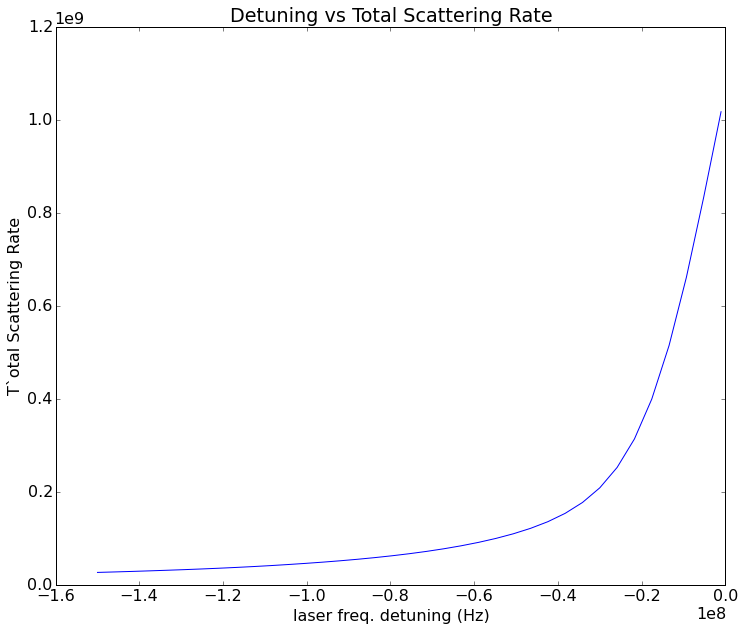

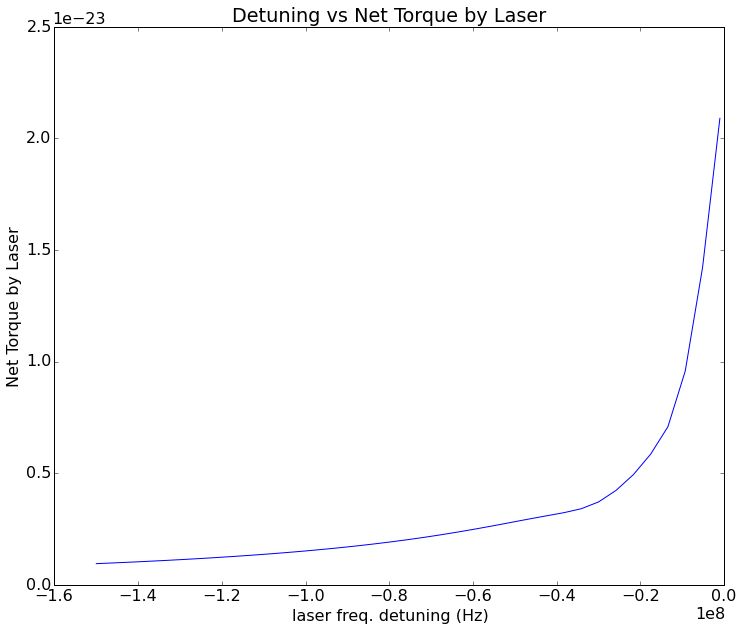

In [5]:
%matplotlib inline
#Adopted from MATLAB code by Charles Xu.
#Steven B. Torrisi Summer 2015

import numpy as np
import scipy as sp
import scipy.optimize as opt
import scipy.integrate as integ
import matplotlib.pyplot as plt
from scipy.constants import pi
plt.rcParams['font.size'] = 16

#Standard parameters and other constants
hbar=1.054E-34;
c=2.9979E8;
lambd=313.112E-9;   #transition wavelength

k=2*pi/lambd;       #Be+ laser wavenumber; assuming offset dw is sufficiently 
                    #small that the shift in the wave number due to dw/(2*pi) can be neglected

kB=1.38E-23;        #Boltzmann's constant
m=8.96*1.673E-27;   # Be+ ion mass

#Input parameters
lowest_df = -150.0E6;     #lowest (most red) detuning of laser beam from atomic 
                          #transition frequency; in Hz; negative numbers correspond to red detuning.
highest_df = -1.0E6;      #highest tuning of the laser beam frequency
incr = 4.0E6;             #increment to be used in going from lowest frequency tuning to highest.
                          #If increment greater than highest-lowest, then only the lowest
                          #frequency detuning will be evaluated
N = int(round((highest_df-lowest_df)/incr));
df = np.linspace(lowest_df,highest_df,N) #Go from lowest df to highest in N steps
                                         #(interpolates linearly)
dw = 2*pi*df;
d = 40.00E-6;               #offset of laser beam from the center of the array in meters, 
                    #positive offsets corresponds to miving the laser beam to the side of 
                    #the cloud (or array) that is receding from the laser beam direction
WR = 2*pi*45.0E3;           #angular rotation frequency in s^{-1}
RP = 225.0E-6;              #radius of ion array in meters


R_bar=(hbar*k)**2/(2*m);    #recoil energy
T = 20.0E-3               #initial guess in temperature in Kelvin

global GAMMA, VK, RNORM, U0, RP, WR, WY, d, S0, SIG
#Define Globals
RNORM=R_bar/(hbar*k);      #A reduced recoil energy
GAMMA=2*pi*18.0E6;         #natural linewidth
VK=GAMMA/(2*k);            # Reduced line width
U0=np.sqrt(2*kB*T/m);      #initial thermal velocity used in Boltzmann factor 
WY=30.0E-6                 #beam width in meters
SIG=2.77E9                 # density at origin
S0=.786                    # Saturation parameter

def density(x,y):
    """
    Defines a density scaling which returns 0 outside of the circular bounds of the crystal.
    Useful because it allows for rectangular integration bounds (i.e. [-r,r])
    instead of complicated functional bounds which are difficult to work with.
    """
    global RP
    rad=x**2+y**2
    if rad<=(RP**2):
        return np.sqrt(1-(rad)/RP**2)
    else:
        return 0

def dEnosaturation(u,detun,offset=d):
    global GAMMA, VK, RNORM,  U0, RP, WR, WY, counter
        
    delta = 2.*detun/GAMMA;
    ret = integ.tplquad(lambda y,x,v:\
                        density(x,y)\
                        *np.exp(-(y-offset)**2 /WY**2) *\
                        ((v)+2*RNORM/u)*np.exp(-v**2)/\
                        (1+(delta-(WR*y/VK)-(u*v/VK))**2),\
                        -np.inf, np.inf,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*RP, lambda x,y: RP)
    
    #print("Integral Evaluated",ret[0],"with temperature",u**2*8.96*1.673E-27/(2*1.38E-23))
    counter+=1
    return ret[0]

def dEcomplete(u,detun,offset=d):
    global GAMMA, VK, RNORM,  U0, RP, WR, WY, S0, counter
    delta = 2.*detun/GAMMA;
    ret = integ.tplquad(lambda y,x,v:\
                        density(x,y)\
                        *np.exp(-(y-offset)**2 /WY**2) *\
                        ((v)+2*RNORM/u)*np.exp(-v**2)/\
                        ((1+2*S0*np.exp(-2*(y-d)**2 /WY**2)\
                          +(delta-(WR*y/VK)-(u*v/VK))**2)),\
                        -np.inf, np.inf,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*RP, lambda x,y: RP)
    
    #print("Integral Evaluated",ret[0],"with temperature",u**2*8.96*1.673E-27/(2*1.38E-23))
    counter+=1
    return ret[0]

def totalscatter(ueq,detun):

    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    delta = 2.*detun/GAMMA;
    constants= GAMMA*S0*SIG*ueq/np.sqrt(np.pi)
    ret = integ.tplquad(lambda y,x,v:\
                        \
                        density(x,y)\
                        *np.exp(-2*(y-d)**2 /WY**2) *\
                        np.exp(-v**2)/\
                        (1+2*S0*np.exp(-2*(y-d)**2 /WY**2)+\
                        (delta-(WR*y/VK)-(ueq*v/VK))**2),\
                        \
                        -np.inf, np.inf,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*RP, lambda x,y: RP)
    
    return ret[0]*constants

def totaltorque(ueq,detun):
    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    delta = 2.*detun/GAMMA;
    constants= (hbar*k)*GAMMA*S0*SIG*ueq/np.sqrt(np.pi)
    ret = integ.tplquad(lambda v,x,y:\
                        \
                        density(x,y)\
                        *np.exp(-2*(y-d)**2 /WY**2)*y*\
                        np.exp(-v**2)/\
                        (1+2*S0*np.exp(-2*(y-d)**2 /WY**2)+\
                        (delta-(WR*y/VK)-(ueq*v/VK))**2),\
                        \
                        -1*RP, RP,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*np.inf, lambda x,y: np.inf,\
                        epsabs=1.49e-10, epsrel=1.49e-10)    
    
    return ret[0]*constants

def getroot(detoffset):
    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    print("Trying detuning",detoffset[0]," and offset ",detoffset[1])
    return (opt.brentq(dEver3,umin,umax,args=(detoffset[0],detoffset[1]),xtol=1e-6, rtol=3.0e-8))**2*m/(2*kB)

def getrootdetun(detun):
    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    print("Trying detuning",detun)
    return (opt.brentq(dEver3,umin,umax,args=(detun,3.98794261e-05),xtol=1e-6, rtol=3.0e-8))**2*m/(2*kB)
#########################################
U=[0] * (N)
Sc=[0] * (N)
To=[0]*(N)

Tmax=1.0E-1
Tmin=1.0E-5
umax=np.sqrt(Tmax*kB*2/m)
umin=np.sqrt(Tmin*kB*2/m)
global counter
counter=0
print("Beginning...")

#opt.fmin(getroot,[-50.0E6,15.0E-6],args=(detun))
#print(opt.minimize(getroot,[-50.0E6,50.0E-6],method='TNC',bounds=[[-160.0E6,-1.0E6],[0,220.0E-6]]))

#print(opt.minimize(getrootdetun,[-10.0E6] ,method='TNC',bounds=[[-150.0E6,-5.0E6]]))
#return
d=20.0E-06
"""
The following for loop is currently configured to conduct a parameter scan of the 

"""
for R in range(N):
    print("-------------")
    print("Feeding in detuning",dw[R]/(2*3.14159), R+1, "of", range(N)[-1]+1, "Evaluations")
    try:
        U[R]=opt.brentq(dEcomplete,umin,umax,args=(dw[R]),xtol=1e-4, rtol=3.0e-7)
    except:
        try: 
            U[R]=opt.brentq(dEcomplete,umin*.1,umax*10,args=(dw[R]),xtol=1e-4, rtol=3.0e-7)
        except:
            U[R]=opt.brentq(dEcomplete,umin*.01,umax*100,args=(dw[R]),xtol=1e-4, rtol=3.0e-7)
    print("u/T recorded:",U[R],((U[R])*U[R]*8.96*1.673E-27/(2*1.38E-23)),"after",counter,"integral calls.")
    Sc[R]=totalscatter(U[R],dw[R])
    To[R]=totaltorque(U[R],dw[R])
    counter=0

    
#plt.figure(figsize=(12, 10))
Teq=[x**2*m/(2*kB) for x in U];
#b=plt.plot(df,Teq)
#b=plt.xlabel('laser freq. detuning (Hz)')
#b=plt.ylabel('equilibrium temp (K)')
#b=plt.title('Plot of the Equilibrium Temperature')
plt.figure(figsize=(12, 10))
print(Teq)
print(min(Teq))

a=plt.plot(df,Teq)
a=plt.xlabel('laser freq. detuning (Hz)')
a=plt.ylabel('equilibrium temp (K)')
a=plt.title('Plot of the Equilibrium Temperature')
a=plt.yscale('log', nonposy='clip')

plt.figure(figsize=(12, 10))
c=plt.plot(df,Sc)
c=plt.xlabel('laser freq. detuning (Hz)')
c=plt.ylabel('T`otal Scattering Rate')
c=plt.title('Detuning vs Total Scattering Rate')

plt.figure(figsize=(12, 10))
d=plt.plot(df,To)
d=plt.xlabel('laser freq. detuning (Hz)')
d=plt.ylabel('Net Torque by Laser')
d=plt.title('Detuning vs Net Torque by Laser')

print(U)


# The code below is configured to conduct a 2-dimensional parameter scan

In [2]:
%matplotlib inline
#Adopted from MATLAB code by Charles Xu.
#Steven B. Torrisi Summer 2015

import time
import numpy as np
import scipy as sp
import scipy.optimize as opt
import scipy.integrate as integ
import matplotlib.pyplot as plt
from scipy.constants import pi
plt.rcParams['font.size'] = 16

#Standard parameters and other constants
hbar=1.054E-34;
c=2.9979E8;
lambd=313.112E-9;   #transition wavelength

k=2*pi/lambd;       #Be+ laser wavenumber; assuming offset dw is sufficiently 
                    #small that the shift in the wave number due to dw/(2*pi) can be neglected

kB=1.38E-23;        #Boltzmann's constant
m=8.96*1.673E-27;   # Be+ ion mass

#Input parameters
lowest_df = -150.0E6;     #lowest (most red) detuning of laser beam from atomic 
                          #transition frequency; in Hz; negative numbers correspond to red detuning.
highest_df = -1.0E6;      #highest tuning of the laser beam frequency
incr = 4.0E6;             #increment to be used in going from lowest frequency tuning to highest.
                          #If increment greater than highest-lowest, then only the lowest
                          #frequency detuning will be evaluated
N = int(round((highest_df-lowest_df)/incr));
df = np.linspace(lowest_df,highest_df,N) #Go from lowest df to highest in N steps
                                         #(interpolates linearly)
dw = 2*pi*df;
d = 40.00E-6;               #offset of laser beam from the center of the array in meters, 
                    #positive offsets corresponds to miving the laser beam to the side of 
                    #the cloud (or array) that is receding from the laser beam direction
WR = 2*pi*45.0E3;           #angular rotation frequency in s^{-1}
RP = 225.0E-6;              #radius of ion array in meters


R_bar=(hbar*k)**2/(2*m);    #recoil energy
T = 20.0E-3               #initial guess in temperature in Kelvin

global GAMMA, VK, RNORM, U0, RP, WR, WY, d, S0, SIG
#Define Globals
RNORM=R_bar/(hbar*k);      #A reduced recoil energy
GAMMA=2*pi*18.0E6;         #natural linewidth
VK=GAMMA/(2*k);            # Reduced line width
U0=np.sqrt(2*kB*T/m);      #initial thermal velocity used in Boltzmann factor 
WY=30.0E-6                 #beam width in meters
SIG=2.77E9                 # density at origin
S0=.5                    # Saturation parameter

def density(x,y):
    """
    Defines a density scaling which returns 0 outside of the circular bounds of the crystal.
    Useful because it allows for rectangular integration bounds (i.e. [-r,r])
    instead of complicated functional bounds which are difficult to work with.
    """
    global RP
    rad=x**2+y**2
    if rad<=(RP**2):
        return np.sqrt(1-(rad)/RP**2)
    else:
        return 0

def dEnosaturation(u,detun,offset=d):
    global GAMMA, VK, RNORM,  U0, RP, WR, WY, counter
        
    delta = 2.*detun/GAMMA;
    ret = integ.tplquad(lambda y,x,v:\
                        density(x,y)\
                        *np.exp(-(y-offset)**2 /WY**2) *\
                        ((v)+2*RNORM/u)*np.exp(-v**2)/\
                        (1+(delta-(WR*y/VK)-(u*v/VK))**2),\
                        -np.inf, np.inf,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*RP, lambda x,y: RP)
    
    #print("Integral Evaluated",ret[0],"with temperature",u**2*8.96*1.673E-27/(2*1.38E-23))
    counter+=1
    return ret[0]

def dEcomplete(u,detun,offset=d):
    global GAMMA, VK, RNORM,  U0, RP, WR, WY, S0, counter
        
    delta = 2.*detun/GAMMA;
    ret = integ.tplquad(lambda y,x,v:\
                        density(x,y)\
                        *np.exp(-(y-offset)**2 /WY**2) *\
                        ((v)+2*RNORM/u)*np.exp(-v**2)/\
                        ((1+2*S0*np.exp(-2*(y-d)**2 /WY**2)\
                          +(delta-(WR*y/VK)-(u*v/VK))**2)),\
                        -np.inf, np.inf,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*RP, lambda x,y: RP)
    
    #print("Integral Evaluated",ret[0],"with temperature",u**2*8.96*1.673E-27/(2*1.38E-23))
    counter+=1
    return ret[0]

def totalscatter(ueq,detun):

    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    delta = 2.*detun/GAMMA;
    constants= GAMMA*S0*SIG*ueq/np.sqrt(np.pi)
    ret = integ.tplquad(lambda y,x,v:\
                        \
                        density(x,y)\
                        *np.exp(-2*(y-d)**2 /WY**2) *\
                        np.exp(-v**2)/\
                        (1+2*S0*np.exp(-2*(y-d)**2 /WY**2)+\
                        (delta-(WR*y/VK)-(ueq*v/VK))**2),\
                        \
                        -np.inf, np.inf,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*RP, lambda x,y: RP)
    
    return ret[0]*constants

def totaltorque(ueq,detun):
    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    delta = 2.*detun/GAMMA;
    constants= (hbar*k)*GAMMA*S0*SIG*ueq/np.sqrt(np.pi)
    ret = integ.tplquad(lambda v,x,y:\
                        \
                        density(x,y)\
                        *np.exp(-2*(y-d)**2 /WY**2)*y*\
                        np.exp(-v**2)/\
                        (1+2*S0*np.exp(-2*(y-d)**2 /WY**2)+\
                        (delta-(WR*y/VK)-(ueq*v/VK))**2),\
                        \
                        -1*RP, RP,\
                        lambda x: -1*RP, lambda x: RP,\
                        lambda x,y: -1*np.inf, lambda x,y: np.inf,\
                        epsabs=1.49e-10, epsrel=1.49e-10)    
    
    return ret[0]*constants

def getroot(detoffset):
    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    print("Trying detuning",detoffset[0]," and offset ",detoffset[1])
    return (opt.brentq(dEver3,umin,umax,args=(detoffset[0],detoffset[1]),xtol=1e-6, rtol=3.0e-8))**2*m/(2*kB)

def getrootdetun(detun):
    global GAMMA, VK, RNORM, U0, RP, WR, WY, d,S0,SIG
    print("Trying detuning",detun)
    return (opt.brentq(dEver3,umin,umax,args=(detun,3.98794261e-05),xtol=1e-6, rtol=3.0e-8))**2*m/(2*kB)
#########################################
#Sc=[0] * (N)
#To=[0]*(N)
#print(dE1(1,dw[0],y))
#print(totalscatter(np.sqrt(.05*kB*2/m),-20.0E6))

Tmax=1.0E-1
Tmin=1.0E-5
umax=np.sqrt(Tmax*kB*2/m)
umin=np.sqrt(Tmin*kB*2/m)
global counter
counter=0
print("Beginning...")

#opt.fmin(getroot,[-50.0E6,15.0E-6],args=(detun))
#print(opt.minimize(getroot,[-50.0E6,50.0E-6],method='TNC',bounds=[[-160.0E6,-1.0E6],[0,220.0E-6]]))

#print(opt.minimize(getrootdetun,[-10.0E6] ,method='TNC',bounds=[[-150.0E6,-5.0E6]]))
#return

df = np.linspace(-115.0E6,-5.0E6,30)
doff= np.linspace(0.00,100.0E-6,30)
dw = 2*pi*df;
U=np.zeros([len(df),len(doff)])

for R in range(len(dw)):
    for D in range(len(doff)):
        
        print("-------------")
        print("Feeding in detuning/offset",dw[R]/(2*3.14159),doff[D], R*(len(doff))+D+1, "of", len(df)*len(doff), "Evaluations")
        try:
            U[R][D]=opt.brentq(dEcomplete,umin,umax,args=(dw[R],doff[D]),xtol=1e-4, rtol=3.0e-7)
        except:
            try: 
                U[R][D]=opt.brentq(dEcomplete,umin*.1,umax*10,args=(dw[R],doff[D]),xtol=1e-4, rtol=3.0e-7)
            except:
                U[R][D]=opt.brentq(dEcomplete,umin*.01,umax*100,args=(dw[R],doff[D]),xtol=1e-4, rtol=3.0e-7)
        print("u/T recorded:",U[R][D],((U[R][D])*U[R][D]*8.96*1.673E-27/(2*1.38E-23)),"after",counter,"integral calls.")

        counter=0
Teq=np.array([x**2*m/(2*kB) for x in U]);
print(U)
print(Teq)

#plt.figure(figsize=(12, 10))
#b=plt.plot(df,Teq)
#b=plt.xlabel('laser freq. detuning (Hz)')
#b=plt.ylabel('equilibrium temp (K)')
#b=plt.title('Plot of the Equilibrium Temperature')
plt.figure(figsize=(12, 10))
#cmap = plt.get_cmap('PiYG')
#levels = MaxNLocator(nbins=15).tick_values(Teq.min(), Teq.max())
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#im = plt.pcolormesh(df, doff, Teq, cmap=cmap, norm=norm)
CS = plt.contour(doff, df, Teq)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')
"""
a=plt.plot(df,Teq)
a=plt.xlabel('laser freq. detuning (Hz)')
a=plt.ylabel('equilibrium temp (K)')
a=plt.title('Plot of the Equilibrium Temperature')
a=plt.yscale('log', nonposy='clip')

returnplt.figure(figsize=(12, 10))
c=plt.plot(df,Sc)
c=plt.xlabel('laser freq. detuning (Hz)')
c=plt.ylabel('T`otal Scattering Rate')
c=plt.title('Detuning vs Total Scattering Rate')

plt.figure(figsize=(12, 10))
d=plt.plot(df,To)
d=plt.xlabel('laser freq. detuning (Hz)')
d=plt.ylabel('Net Torque by Laser')
d=plt.title('Detuning vs Net Torque by Laser')

print(U)
"""

Beginning...
-------------
Feeding in detuning/offset -115000097.136 0.0 1 of 900 Evaluations
u/T recorded: 2.14700504812 0.0025035772686 after 10 integral calls.
-------------
Feeding in detuning/offset -115000097.136 3.44827586207e-06 2 of 900 Evaluations
u/T recorded: 2.18187204886 0.00258555288959 after 10 integral calls.
-------------
Feeding in detuning/offset -115000097.136 6.89655172414e-06 3 of 900 Evaluations
u/T recorded: 2.2159173722 0.00266687090331 after 9 integral calls.
-------------
Feeding in detuning/offset -115000097.136 1.03448275862e-05 4 of 900 Evaluations
u/T recorded: 2.2492857605 0.00274779378132 after 9 integral calls.
-------------
Feeding in detuning/offset -115000097.136 1.37931034483e-05 5 of 900 Evaluations
u/T recorded: 2.28198506343 0.0028282673726 after 10 integral calls.
-------------
Feeding in detuning/offset -115000097.136 1.72413793103e-05 6 of 900 Evaluations
u/T recorded: 2.31406107805 0.00290833549631 after 10 integral calls.
-------------
Fee

KeyboardInterrupt: 

# Execute the code below after conducting a 2d scan in the cell above to make a heat map

In [ ]:
#
%matplotlib inline
import time
start_time = time.time()
import numpy as np
import scipy as sp
import scipy.optimize as opt
import scipy.integrate as integ
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
#print(Teq)
CS = plt.pcolor(doff, df, Teq)
CS=plt.xlabel('Laser Offset (um)')
CS=plt.ylabel('Laser Detuning (MHz)')
CS=plt.title('WY=100 um:Equilibrium Temperature')
plt.colorbar()
print("Minimum temperature:",Teq.min())
#plt.clabel(CS, inline=1, fontsize=10)
#plt.title('Simplest default with labels')